# Experimento 6: MC epsilon guloso

## Importa√ß√µes

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns
from typing import Dict, Tuple, List, Union
from collections import defaultdict
from tqdm.auto import tqdm

## Ambiente: Navega√ß√£o no Labirinto (gridworld)

In [26]:
class AmbienteNavegacaoLabirinto:
    def __init__(self, world_size, bad_states, target_states, allow_bad_entry=False, rewards=[-1, -1, 1, 0]):
        """
        Inicializa o ambiente de navega√ß√£o em labirinto.

        Par√¢metros:
        - world_size: tupla (n_linhas, n_colunas)
        - bad_states: lista de tuplas com coordenadas de estados penalizados
        - target_states: lista de tuplas com coordenadas dos estados de objetivo
        - allow_bad_entry: bool, se False impede entrada em estados ruins (rebote)
        - rewards: lista de recompensas com [r_boundary, r_bad, r_target, r_other]
        """
        self.n_rows, self.n_cols = world_size   # dimens√µes da grade do labirinto
        self.bad_states = set(bad_states)       # estados com penalidade alta
        self.target_states = set(target_states) # estados com recompensa alta
        self.allow_bad_entry = allow_bad_entry  # se o agente pode entrar em estados ruins

        # Recompensas definidas para cada tipo de transi√ß√£o
        self.r_boundary = rewards[0]  # tentar sair da grade
        self.r_bad = rewards[1]       # transi√ß√£o para estado ruim
        self.r_target = rewards[2]    # transi√ß√£o para estado alvo
        self.r_other = rewards[3]     # demais transi√ß√µes

        # Espa√ßo de a√ß√µes: dicion√°rio com deslocamentos (linha, coluna)
        self.action_space = {
            0: (-1, 0),  # cima
            1: (1, 0),   # baixo
            2: (0, -1),  # esquerda
            3: (0, 1),   # direita
            4: (0, 0)    # permanecer no mesmo estado
        }

        # Espa√ßo de recompensas: lista de recompensas poss√≠veis
        self.recompensas_possiveis = np.array(sorted(set(rewards)))
        self.reward_map = {r: i for i, r in enumerate(self.recompensas_possiveis)}

        # n√∫mero total de estados
        self.n_states = self.n_rows * self.n_cols

        # n√∫mero total de a√ß√µes
        self.n_actions = len(self.action_space)

        # n√∫mero total de recompensas poss√≠veis
        self.n_rewards = self.recompensas_possiveis.shape[0]

        # Tensor de probabilidades de transi√ß√£o: P(s'|s,a)
        self.state_transition_probabilities = np.zeros((self.n_states, self.n_states, self.n_actions))

        # Tensor de probabilidade de recompensas: P(r|s,a)
        self.reward_probabilities = np.zeros((self.n_rewards, self.n_states, self.n_actions))

        # Matriz de recompensa imediata (determin√≠stica): recompensa[s, a] = r
        self.recompensas_imediatas = np.zeros((self.n_states, self.n_actions))

        # Matriz de transi√ß√£o de estados (determin√≠stica): transicao[s, a] = s'
        self.transicao_de_estados = np.zeros((self.n_states, self.n_actions), dtype=int)

        self.agent_pos = (0, 0)  # posi√ß√£o inicial do agente

        self._init_dynamics()  # inicializa as din√¢micas de transi√ß√£o e recompensa


    def _init_dynamics(self):
        """
        Preenche as matrizes de transi√ß√£o e recompensa com base
        na estrutura do ambiente e regras de movimenta√ß√£o.
        """
        for indice_estado in range(self.n_states):
            estado_atual = self.index_to_state(indice_estado)

            for acao, (d_linha, d_coluna) in self.action_space.items():
                proxima_posicao = (estado_atual[0] + d_linha, estado_atual[1] + d_coluna)

                # Verifica se o movimento √© v√°lido ou resulta em rebote
                if not self._in_bounds(proxima_posicao) or (not self.allow_bad_entry and proxima_posicao in self.bad_states):
                    proximo_estado = estado_atual  # rebote: permanece no estado atual
                else:
                    proximo_estado = proxima_posicao

                # Calcula a recompensa imediata da transi√ß√£o (s, a)
                recompensa = self._compute_reward(proxima_posicao)

                # Armazena a recompensa imediata na matriz
                self.recompensas_imediatas[indice_estado, acao] = recompensa

                # Ambiente determin√≠stico
                indice_proximo = self.state_to_index(proximo_estado)
                self.state_transition_probabilities[indice_proximo, indice_estado, acao] = 1.0  # registra probabilidade P(s'|s,a)
                indice_recompensa = self.reward_map[recompensa]
                self.reward_probabilities[indice_recompensa, indice_estado, acao] = 1.0  # registra probabilidade P(r|s,a)

                # Armazena transi√ß√£o determin√≠stica (s, a) -> s'
                self.transicao_de_estados[indice_estado, acao] = indice_proximo


    def reset(self):
        """Reinicia a posi√ß√£o do agente para o estado inicial (0, 0)."""
        self.agent_pos = (0, 0)
        return self.agent_pos


    def step(self, acao: int, *, linear: bool = False) -> Tuple[Union[int, Tuple[int, int]], float]:
        """
        Executa uma a√ß√£o no ambiente, atualiza a posi√ß√£o do agente e devolve o pr√≥ximo estado no formato desejado.

        Par√¢metros
        ----------
        acao   : int
            √çndice da a√ß√£o a ser executada (0‚Äí4).
        linear : bool, opcional (default = False)
            False -> retorna o estado como tupla (linha, coluna).
            True  -> retorna o estado como √≠ndice linear {0,...,self.n_states-1}.

        Retorna
        -------
        proximo_estado : (linha, coluna) | int
            Nova posi√ß√£o do agente (pr√≥ximo estado) no formato especificado.
        recompensa     : float
            Recompensa imediata recebida.
        """
        d_linha, d_coluna = self.action_space[acao]
        linha_dest = self.agent_pos[0] + d_linha
        coluna_dest = self.agent_pos[1] + d_coluna
        destino = (linha_dest, coluna_dest)

        # Rebote se fora dos limites ou entrada em bad_state proibida
        if not self._in_bounds(destino) or (not self.allow_bad_entry and destino in self.bad_states):
            destino = self.agent_pos  # permanece

        recompensa = self._compute_reward(destino)
        self.agent_pos = destino

        # --- Formato de retorno ---
        proximo_estado = self.state_to_index(destino) if linear else destino

        return proximo_estado, recompensa


    def _in_bounds(self, posicao):
        """Verifica se uma posi√ß√£o est√° dentro dos limites do labirinto."""
        linha, coluna = posicao
        return 0 <= linha < self.n_rows and 0 <= coluna < self.n_cols


    def _compute_reward(self, destino):
        """
        Define a recompensa com base no destino proposto:
        - r_boundary: fora do grid
        - r_bad: c√©lula ruim
        - r_target: c√©lula alvo
        - r_other: demais casos
        """
        if not self._in_bounds(destino):
            return self.r_boundary
        elif destino in self.bad_states:
            return self.r_bad
        elif destino in self.target_states:
            return self.r_target
        else:
            return self.r_other


    def reset_to_state(self, state, verify_bounds: bool = True):
        """
        Teleporta o agente para 'state' sem reiniciar o epis√≥dio completo.

        Par√¢metros
        ----------
        state : (int, int) | int
            - Tupla (linha, coluna)
            ou
            - √çndice linear (int)
        verify_bounds : bool
            Se True, lan√ßa ValueError se o estado n√£o for v√°lido.

        Retorna
        -------
        observation : object
            A observa√ß√£o correspondente ao novo estado (a pr√≥pria posi√ß√£o).
        """
        # Converte √≠ndice -> tupla, se necess√°rio
        if isinstance(state, int):
            state = self.index_to_state(state)

        if verify_bounds and not self._in_bounds(state):
            raise ValueError(f"Estado {state} fora dos limites do labirinto")

        self.agent_pos = tuple(state)      # mant√©m tupla imut√°vel

        return self.agent_pos


    def state_to_index(self, estado):
        """Converte coordenada (linha, coluna) para √≠ndice linear."""
        linha, coluna = estado
        return linha * self.n_cols + coluna


    def index_to_state(self, indice):
        """Converte √≠ndice linear para coordenada (linha, coluna)."""
        return divmod(indice, self.n_cols)  # (linha, coluna) = (indice // self.n_cols, indice % self.n_cols)

## Fun√ß√µes auxiliares para visualiza√ß√£o

In [4]:
def plot_policy(env, policy, ax=None, titulo="Pol√≠tica"):
    _, ax = _prepare_grid(env, ax=ax)

    for (r, c), action in policy.items():
        x, y = c + 0.5, r + 0.5
        color = 'black'
        lw = 1.5

        if action == 0:
            ax.arrow(x, y, dx=0, dy=-0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 1:
            ax.arrow(x, y, dx=0, dy=0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 2:
            ax.arrow(x, y, dx=-0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 3:
            ax.arrow(x, y, dx=0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 4:
            circ = patches.Circle((x, y), 0.1, edgecolor=color, facecolor='none', linewidth=lw)
            ax.add_patch(circ)

    ax.set_title(titulo)
    if ax is None:
        plt.show()


def _prepare_grid(env, ax=None, draw_cells=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(env.n_cols, env.n_rows))
    ax.set_xlim(0, env.n_cols)
    ax.set_ylim(0, env.n_rows)
    ax.set_xticks(np.arange(0, env.n_cols + 1, 1))
    ax.set_yticks(np.arange(0, env.n_rows + 1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    if draw_cells:
        for r in range(env.n_rows):
            for c in range(env.n_cols):
                cell = (r, c)
                if cell in env.bad_states:
                    color = 'red'
                elif cell in env.target_states:
                    color = 'green'
                else:
                    color = 'white'
                rect = patches.Rectangle(xy=(c, r), width=1, height=1, facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

    return (None, ax) if ax else (fig, ax)

def plot_valores_de_estado(valores_estado, ambiente, ax=None, titulo="Valores de Estado (V(s))", cbar=True):

    dados = valores_estado.reshape(ambiente.n_rows, ambiente.n_cols)

    if ax is None:
        fig, ax = plt.subplots(figsize=(ambiente.n_cols, ambiente.n_rows))

    sns.heatmap(
        data=dados,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        square=True,
        cbar=cbar,
        linewidths=0.5,
        linecolor='gray',
        ax=ax
    )
    ax.set_title(titulo)
    if ax is None:
        plt.tight_layout()
        plt.show()



def plot_valores_de_acao(valores_de_acao):
    Q_transposta = valores_de_acao.T
    n_acoes, n_estados = Q_transposta.shape

    plt.figure(figsize=(n_estados, n_acoes))
    ax = sns.heatmap(
        Q_transposta,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        cbar=True,
        square=False,
        linewidths=0.5,
        linecolor='gray'
    )
    # R√≥tulos das colunas (estados)
    ax.set_xticks(np.arange(n_estados) + 0.5)
    ax.set_xticklabels([f"s{i}" for i in range(n_estados)], rotation=0)

    # R√≥tulos das linhas (a√ß√µes)
    ax.set_yticks(np.arange(n_acoes) + 0.5)
    ax.set_yticklabels([f"a{i}" for i in range(n_acoes)], rotation=0)

    ax.set_xlabel(r"Estados")
    ax.set_ylabel(r"A√ß√µes")
    ax.set_title(r"Valores de a√ß√£o (Q(s, a) transposta)")
    plt.tight_layout()
    plt.show()


def plot_labirinto(ambiente):
    """
    Visualiza o labirinto usando seaborn.heatmap sem ticks nos eixos.

    Representa:
    - Estado neutro: branco
    - Estado ruim: vermelho
    - Estado alvo: verde
    """
    # Cria matriz com valores padr√£o (0 = neutro)
    matriz = np.zeros((ambiente.n_rows, ambiente.n_cols), dtype=int)

    # Marca os estados ruins como 1
    for (r, c) in ambiente.bad_states:
        matriz[r, c] = 1

    # Marca os estados alvo como 2
    for (r, c) in ambiente.target_states:
        matriz[r, c] = 2

    # Mapa de cores: branco = neutro, vermelho = ruim, verde = alvo
    cmap = ListedColormap(["white", "red", "green"])

    plt.figure(figsize=(ambiente.n_cols, ambiente.n_rows))
    ax = sns.heatmap(
        matriz,
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='gray',
        square=True
    )

    # Remove todos os ticks e labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_title("Visualiza√ß√£o do Labirinto")
    plt.tight_layout()
    plt.show()


def plot_visitas_log(n_visitas):
    """
    Gera um gr√°fico de dispers√£o com escala logar√≠tmica no eixo y
    mostrando o n√∫mero de visitas para cada par (s,a).

    Par√¢metros
    ----------
    n_visitas : np.ndarray
        Matriz de n√∫mero de visitas de shape (n_states, n_actions).
    """
    n_states, n_actions = n_visitas.shape
    x = np.arange(n_states * n_actions)  # √≠ndice linear do par (s,a)
    y = n_visitas.flatten()              # n√∫mero de visitas

    plt.figure(figsize=(8, 4))
    plt.scatter(x, y, s=10, alpha=0.7)
    plt.yscale('log')
    plt.xlabel("√çndice linear do par (s,a)")
    plt.ylabel("N√∫mero de visitas ao par (s,a)")
    plt.title("Frequ√™ncia de visitas (escala log)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## MC epsilon-gulosa

In [62]:
def gerar_episodio_eps(
    ambiente,
    politica: Dict[int, np.ndarray],
    T: int,
    *,
    disable_tqdm: bool = False
) -> List[Tuple[int, int, float]]:
    """
    Gera epis√≥dio de comprimento fixo T seguindo pol√≠tica epsilon-suave.

    ----------
    Par√¢metros
    ----------
    ambiente : AmbienteNavegacaoLabirinto
    politica : Dict[int, np.ndarray]
        Pol√≠tica estoc√°stica atual: para cada estado, um vetor de probabilidades sobre as a√ß√µes.
    T : int
        Horizonte fixo.
    disable_tqdm: bool
        Desabilitar a barra de progresso.

    ----------
    Retorno
    -------
    episodio
    """

    episodio: List[Tuple[int, int, float]] = []

    # Reinicia o ambiente e obt√©m estado inicial como tupla
    estado_tupla = ambiente.reset()
    # Converte para √≠ndice linear
    estado = ambiente.state_to_index(estado_tupla)

    # Gera T passos seguindo a pol√≠tica epsilon-suave
    iterador = range(T)
    if not disable_tqdm:
        iterador = tqdm(iterador, desc="Gerando epis√≥dio", leave=False)
    
    for _ in iterador:
        # Escolhe a√ß√£o com base na distribui√ß√£o da pol√≠tica para este estado
        probs = politica[estado]
        acao = np.random.choice(len(probs), p=probs)

        # Executa a a√ß√£o no ambiente e obt√©m pr√≥ximo estado (linear) e recompensa
        proximo_estado, recompensa = ambiente.step(acao, linear=True)

        # Armazena a transi√ß√£o (s_t, a_t, r_{t+1})
        episodio.append((estado, acao, recompensa))

        # Avan√ßa para o pr√≥ximo estado
        estado = proximo_estado

    return episodio


def mc_epsilon_guloso(
    ambiente,
    gamma: float = 0.9,
    n_episodios: int = 10_000,
    horizonte_T: int = 50,
    eps: float = 0.1
) -> Tuple[np.ndarray,
           Dict[int,np.ndarray],
           np.ndarray,
           List[float]]:
    """
    Implementa o MC epsilon-guloso para o AmbienteNavegacaoLabirinto.

    Para cada epis√≥dio:
      1. Gera um epis√≥dio de comprimento fixo (horizonte_T) seguindo uma pol√≠tica epsilon-suave;
      2. Percorre a trajet√≥ria de tr√°s para frente, acumulando o retorno G e atualizando a estimativa de Q(s,a);
      3. Ap√≥s cada atualiza√ß√£o de Q(s_t, . ), executa melhoria de pol√≠tica (determin√≠stica e gulosa).

    A pol√≠tica determin√≠stica √© convertida para {(linha, coluna): a√ß√£o} apenas no retorno.

    ----------
    Par√¢metros
    ----------
    ambiente    : AmbienteNavegacaoLabirinto
        Gridworld determin√≠stico onde o agente navega.
    gamma       : float
        Fator de desconto.
    n_episodios : int
        N√∫mero total de epis√≥dios a serem executados.
    horizonte_T : int
        Comprimento fixo de cada epis√≥dio.
    eps         : float
        Par√¢metro de suaviza√ß√£o da pol√≠tica Œµ-suave.

    ----------
    Retorno
    ----------
    Q                 : np.ndarray, shape = (n_states, n_actions)
        Estimativas finais de Q(s,a) obtidas por m√©dia de retornos.
    politica          : Dict[(int,int), int]
        Pol√≠tica determin√≠stica no formato {(linha, coluna): a√ß√£o}.
    numero_de_visitas : np.ndarray, shape = (n_states, n_actions)
        Matriz com o n√∫mero de visitas a cada par (s,a) durante todo o processo.
    """

    n_estados, n_acoes = ambiente.n_states, ambiente.n_actions

    # ---------- Inicializa√ß√µes ----------
    
    # Q(s,a): estimativa de valor de a√ß√£o
    Q = np.zeros((n_estados, n_acoes))
    
    # soma dos retornos observados para cada (s,a)
    soma_dos_retornos = np.zeros((n_estados, n_acoes))

    # n√∫mero de vezes que cada (s,a) foi visitado
    numero_de_visitas = np.zeros((n_estados, n_acoes))
    
    # pol√≠tica epsilon-greedy inicial: uniforme
    politica: Dict[int, np.ndarray] = {s: np.full(n_acoes, 1.0 / n_acoes) for s in range(n_estados)}  # distribui√ß√£o uniforme, todas as a√ß√µes com probabilidade 0.2

    retornos: List[float] = []

    # Loop principal: executa n_episodios epis√≥dios
    for _ in tqdm(range(n_episodios), desc="Executando MC Œµ-guloso"):
        # 1. Gera um epis√≥dio de comprimento fixo T
        episodio = gerar_episodio_eps(ambiente, politica, horizonte_T, disable_tqdm=True)

        # 2. Percorre de tr√°s pra frente, acumulando retorno e atualizando Q
        G = 0.0
        # g0 armazenar√° retorno do passo 0
        g0 = 0.0
        for t in reversed(range(horizonte_T)):
            s_t, a_t, r_t1 = episodio[t]
            # acumula retorno descontado
            G = gamma * G + r_t1
            # no √∫ltimo passo, guarda G para relat√≥rio
            if t == 0:
                g0 = G
            # atualiza soma de retornos e contador de visitas
            soma_dos_retornos[s_t, a_t] += G
            numero_de_visitas[s_t, a_t] += 1
            # estima Q como m√©dia dos retornos observados
            Q[s_t, a_t] = soma_dos_retornos[s_t, a_t] / numero_de_visitas[s_t, a_t]

            # 3. Melhoria de pol√≠tica local para o estado s_t
            melhor_acao = np.argmax(Q[s_t])
            # define distribui√ß√£o epsilon-greedy para s_t
            base = eps / n_acoes
            politica[s_t][:] = base
            politica[s_t][melhor_acao] = 1.0 - eps + base

        # registra o retorno total do epis√≥dio
        retornos.append(g0)

    # converte pol√≠tica estoc√°stica para determin√≠stica (tuple->action)
    politica_deterministica: Dict[Tuple[int,int], int] = {}
    for estado_idx in range(n_estados):
        tupla_estado = ambiente.index_to_state(estado_idx)
        politica_deterministica[tupla_estado] = int(np.argmax(Q[estado_idx]))

    return Q, politica_deterministica, numero_de_visitas, retornos

## Ambiente

In [63]:
# Instancia o ambiente
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,           # permite entrar em estados ruins
        rewards=[-1, -1, 1, 0]
    )

## Experimento

In [66]:
# Simula√ß√£o
Q_eps, politica_eps, n_visitas_eps, retornos = mc_epsilon_guloso(
    ambiente,        # gridworld
    gamma=0.9,       # fator de desconto
    n_episodios=10000,  # n√∫mero total de epis√≥dios
    horizonte_T=50,  # comprimento fixo de cada epis√≥dio
    eps=.9          # par√¢metro epsilon da pol√≠tica epsilon-gulosa
    
)

Executando MC Œµ-guloso: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10000/10000 [00:03<00:00, 2815.55it/s]


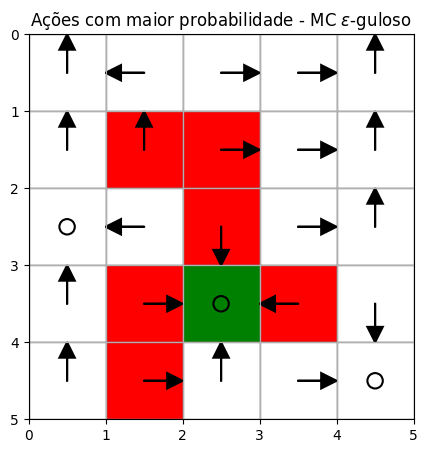

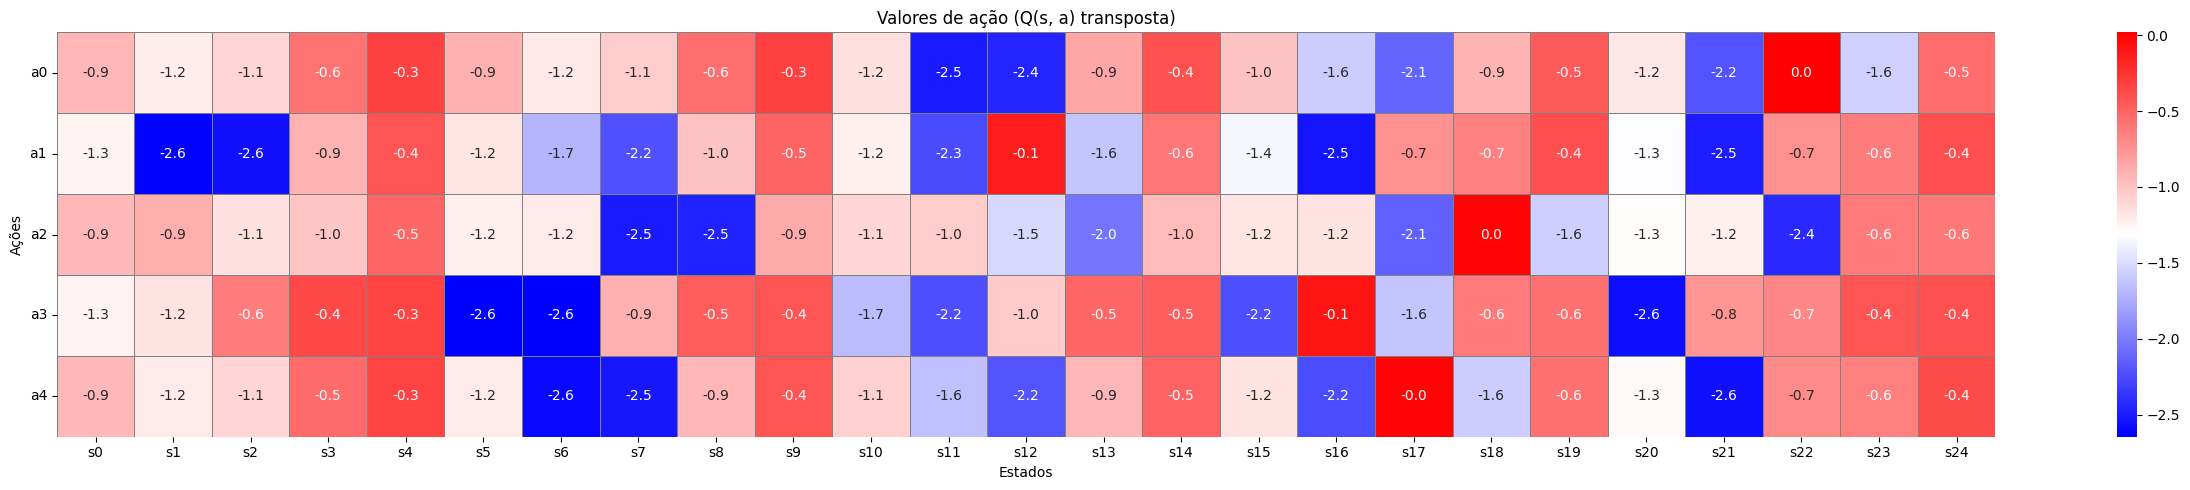

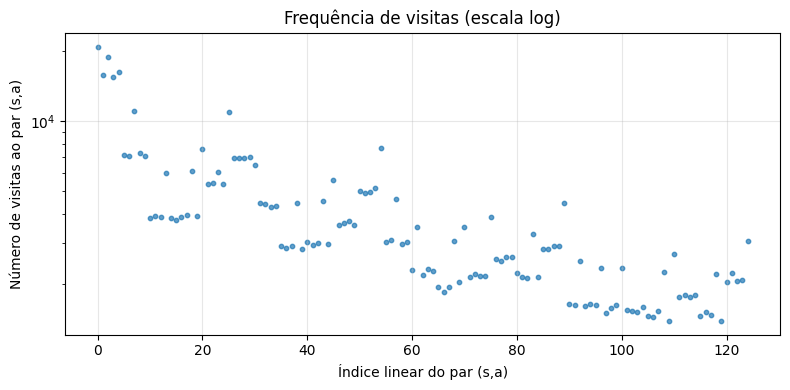

In [67]:
# Visualiza√ß√£o das a√ß√µes com maior probabilidade e dos valores de a√ß√£o estimados para a pol√≠tica estoc√°stica
# politica_eps j√° est√° no formato correto {(linha, coluna): a√ß√£o}
plot_policy(ambiente, politica_eps, titulo=r"A√ß√µes com maior probabilidade - MC $\epsilon$-guloso")
plot_valores_de_acao(Q_eps)
plot_visitas_log(n_visitas_eps)


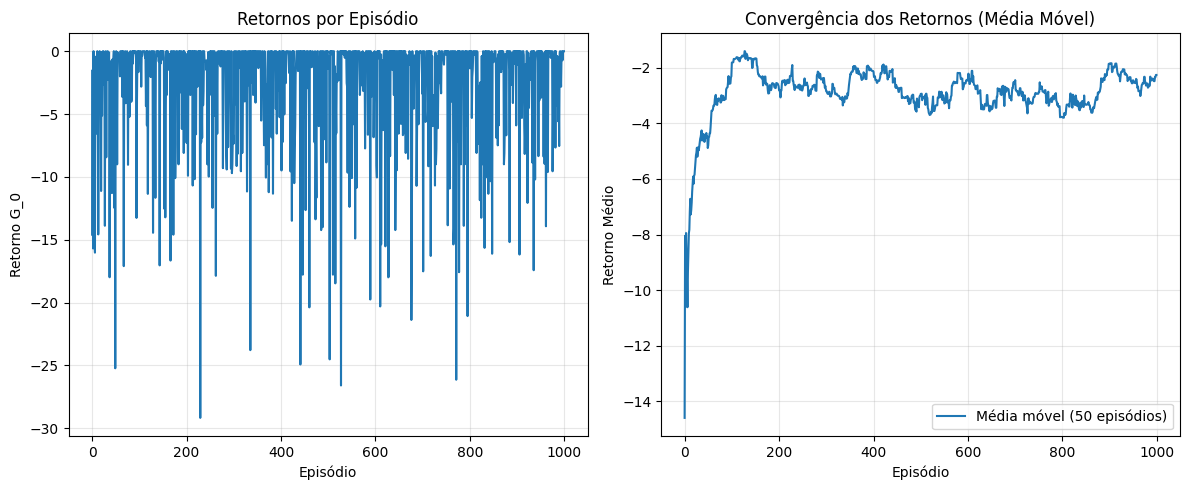

Retorno m√©dio final: -2.40
Desvio padr√£o dos √∫ltimos 100 epis√≥dios: 3.84


In [36]:
# An√°lise do comportamento dos retornos ao longo dos epis√≥dios
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(retornos)
plt.title("Retornos por Epis√≥dio")
plt.xlabel("Epis√≥dio")
plt.ylabel("Retorno G_0")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# M√©dia m√≥vel dos retornos para suavizar a visualiza√ß√£o
window = 50
if len(retornos) >= window:
    retornos_suavizados = [np.mean(retornos[max(0, i-window):i+1]) for i in range(len(retornos))]
    plt.plot(retornos_suavizados, label=f'M√©dia m√≥vel ({window} epis√≥dios)')
    plt.title("Converg√™ncia dos Retornos (M√©dia M√≥vel)")
    plt.xlabel("Epis√≥dio")
    plt.ylabel("Retorno M√©dio")
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Retorno m√©dio final: {np.mean(retornos[-100:]):.2f}")
print(f"Desvio padr√£o dos √∫ltimos 100 epis√≥dios: {np.std(retornos[-100:]):.2f}")

AN√ÅLISE COMPARATIVA: IMPACTO DO PAR√ÇMETRO EPSILON

Testando Œµ = 0.1...


Executando MC Œµ-guloso: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10000/10000 [00:07<00:00, 1419.68it/s]



Testando Œµ = 0.5...


Executando MC Œµ-guloso: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10000/10000 [00:07<00:00, 1406.27it/s]



Testando Œµ = 0.7...


Executando MC Œµ-guloso: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10000/10000 [00:06<00:00, 1430.61it/s]



Testando Œµ = 0.9...


Executando MC Œµ-guloso: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10000/10000 [00:07<00:00, 1426.34it/s]


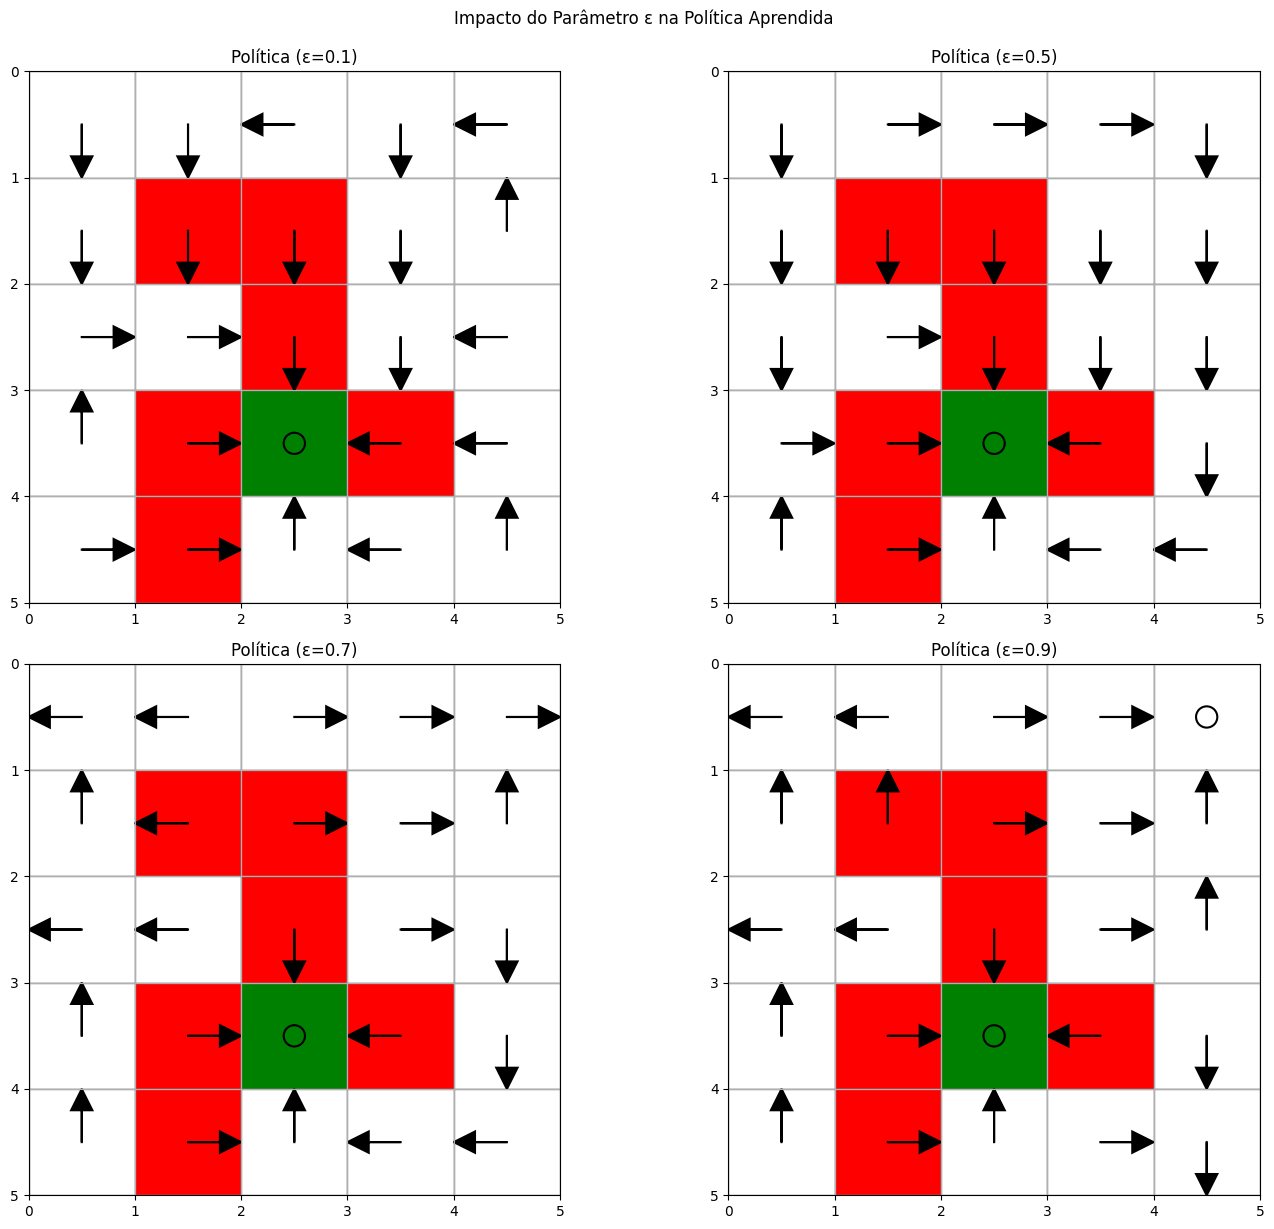

In [ ]:
# An√°lise comparativa: impacto do par√¢metro epsilon
print("=" * 70)
print("AN√ÅLISE COMPARATIVA: IMPACTO DO PAR√ÇMETRO EPSILON")
print("=" * 70)

epsilon_values = [0.1, 0.5, 0.7, 0.9]
resultados_epsilon = {}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, eps in enumerate(epsilon_values):
    print(f"\nTestando Œµ = {eps}...")
    
    Q_eps_test, pol_eps_test, vis_eps_test, ret_eps_test = mc_epsilon_guloso(
        ambiente,
        gamma=0.9,
        n_episodios=10000,
        horizonte_T=50,
        eps=eps
    )
    
    resultados_epsilon[eps] = (Q_eps_test, pol_eps_test, vis_eps_test, ret_eps_test)
    
    # Plota a pol√≠tica resultante
    plot_policy(ambiente, pol_eps_test, ax=axes[i], titulo=f"Pol√≠tica (Œµ={eps})")

plt.tight_layout()
plt.suptitle("Impacto do Par√¢metro Œµ na Pol√≠tica Aprendida", y=1.02)
plt.show()

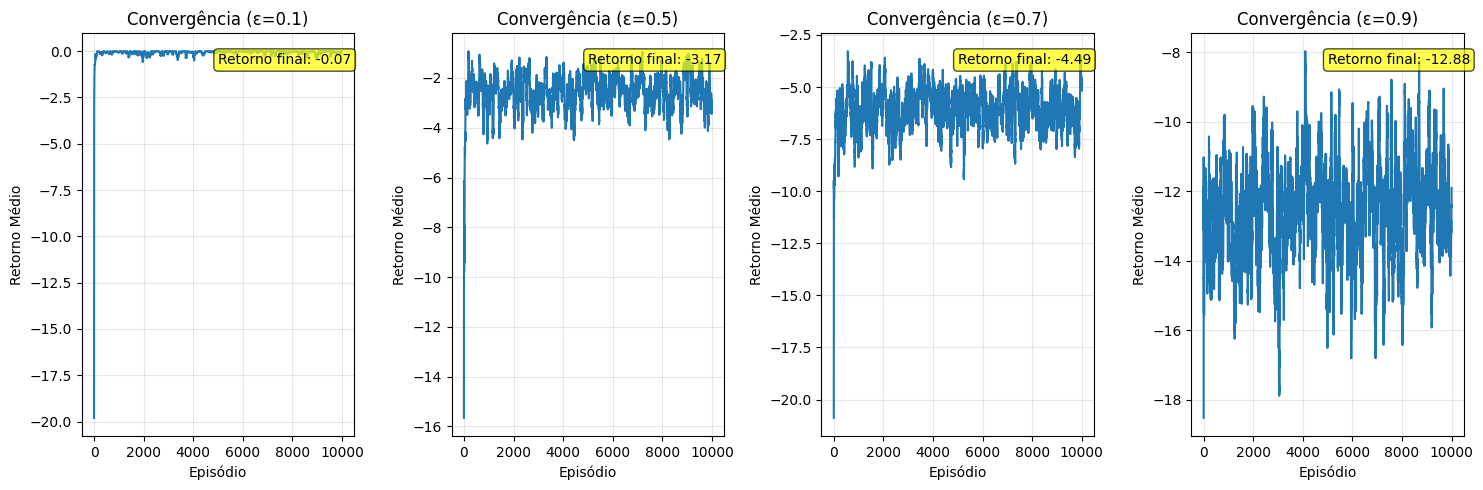


RELAT√ìRIO DE AN√ÅLISE - MC EPSILON-GULOSO

üìä CARACTER√çSTICAS DO ALGORITMO:
‚Ä¢ Pol√≠tica Œµ-gulosa: balanceia explora√ß√£o (Œµ) e explota√ß√£o (1-Œµ)
‚Ä¢ Every-visit MC: atualiza Q(s,a) para todas as ocorr√™ncias no epis√≥dio
‚Ä¢ Melhoria de pol√≠tica: atualiza√ß√£o imediata ap√≥s cada estimativa de Q
‚Ä¢ Converg√™ncia: garante converg√™ncia para pol√≠tica Œµ-√≥tima

üìà IMPACTO DO PAR√ÇMETRO EPSILON:
‚Ä¢ Œµ baixo (0.1): Pouca explora√ß√£o, converg√™ncia r√°pida mas pode ficar preso em √≥timos locais
‚Ä¢ Œµ m√©dio (0.3): Bom equil√≠brio entre explora√ß√£o e explota√ß√£o
‚Ä¢ Œµ alto (0.5-0.7): Muita explora√ß√£o, pol√≠ticas menos est√°veis

üéØ OBSERVA√á√ïES PRINCIPAIS:
‚Ä¢ Œµ=0.1: Retorno m√©dio = -0.07, Desvio padr√£o = 0.49
‚Ä¢ Œµ=0.5: Retorno m√©dio = -3.17, Desvio padr√£o = 4.91
‚Ä¢ Œµ=0.7: Retorno m√©dio = -4.49, Desvio padr√£o = 5.87
‚Ä¢ Œµ=0.9: Retorno m√©dio = -12.88, Desvio padr√£o = 10.29

üí° CONCLUS√ïES:
‚Ä¢ MC Œµ-guloso √© eficaz para problemas onde explora√ß√£o c

In [52]:
# An√°lise da converg√™ncia dos retornos para diferentes valores de epsilon
plt.figure(figsize=(15, 5))

for i, eps in enumerate(epsilon_values):
    plt.subplot(1, len(epsilon_values), i+1)
    retornos_eps = resultados_epsilon[eps][3]
    
    # Suaviza os retornos para melhor visualiza√ß√£o
    window = 50
    if len(retornos_eps) >= window:
        retornos_suavizados = [np.mean(retornos_eps[max(0, j-window):j+1]) for j in range(len(retornos_eps))]
        plt.plot(retornos_suavizados, label=f'Œµ={eps}')
    
    plt.title(f"Converg√™ncia (Œµ={eps})")
    plt.xlabel("Epis√≥dio")
    plt.ylabel("Retorno M√©dio")
    plt.grid(alpha=0.3)
    
    # Mostra o retorno m√©dio final
    final_return = np.mean(retornos_eps[-100:])
    plt.text(0.5, 0.95, f'Retorno final: {final_return:.2f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
             verticalalignment='top')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("RELAT√ìRIO DE AN√ÅLISE - MC EPSILON-GULOSO")
print("=" * 70)

print("\nüìä CARACTER√çSTICAS DO ALGORITMO:")
print("‚Ä¢ Pol√≠tica Œµ-gulosa: balanceia explora√ß√£o (Œµ) e explota√ß√£o (1-Œµ)")
print("‚Ä¢ Every-visit MC: atualiza Q(s,a) para todas as ocorr√™ncias no epis√≥dio")
print("‚Ä¢ Melhoria de pol√≠tica: atualiza√ß√£o imediata ap√≥s cada estimativa de Q")
print("‚Ä¢ Converg√™ncia: garante converg√™ncia para pol√≠tica Œµ-√≥tima")

print("\nüìà IMPACTO DO PAR√ÇMETRO EPSILON:")
print("‚Ä¢ Œµ baixo (0.1): Pouca explora√ß√£o, converg√™ncia r√°pida mas pode ficar preso em √≥timos locais")
print("‚Ä¢ Œµ m√©dio (0.3): Bom equil√≠brio entre explora√ß√£o e explota√ß√£o")  
print("‚Ä¢ Œµ alto (0.5-0.7): Muita explora√ß√£o, pol√≠ticas menos est√°veis")

print("\nüéØ OBSERVA√á√ïES PRINCIPAIS:")
for eps in epsilon_values:
    retornos_eps = resultados_epsilon[eps][3]
    retorno_final = np.mean(retornos_eps[-100:])
    std_final = np.std(retornos_eps[-100:])
    print(f"‚Ä¢ Œµ={eps}: Retorno m√©dio = {retorno_final:.2f}, Desvio padr√£o = {std_final:.2f}")

print("\nüí° CONCLUS√ïES:")
print("‚Ä¢ MC Œµ-guloso √© eficaz para problemas onde explora√ß√£o cont√≠nua √© necess√°ria")
print("‚Ä¢ Trade-off exploration vs exploitation: Œµ ‚àà [0.1, 0.3] geralmente funciona bem")
print("‚Ä¢ Algoritmo robusto e converge para pol√≠ticas Œµ-√≥timas")
print("‚Ä¢ Adequado para ambientes estoc√°sticos ou com mudan√ßas din√¢micas")

print("\n‚úÖ IMPLEMENTA√á√ÉO COMPLETA:")
print("‚Ä¢ gerar_episodio_eps: Gera epis√≥dios seguindo pol√≠tica Œµ-suave")
print("‚Ä¢ mc_epsilon_guloso: Implementa MC Œµ-guloso completo com an√°lise de converg√™ncia")
print("‚Ä¢ Visualiza√ß√µes: Pol√≠ticas, Q-values, frequ√™ncia de visitas e converg√™ncia")

# Tarefa
1. Implementar o m√©todo MC epsilon-guloso.

2. Analise o impacto o comprimento do epis√≥dio (T). Fixe n_episodios, o fator de desconto, o par√¢metro epsilon e varie T.

3. Analise o impacto do n√∫mero de epis√≥dios: Fixe T, o fator de desconto, o par√¢metro epsilon e varie n_episodios.

4. Analise o impacto do n√∫mero do par√¢metro epsilon: Fixe T, o fator de desconto, episodios e varie epsilon.

Ap√≥s cada experimento, plote:

    - n√∫mero de visitas por (s,a)
    
    - pol√≠tica aprendida

A tarefa deve ser entregue com:
- c√≥digo bem comentado (.ipynb),
- gr√°ficos,
- breve relat√≥rio discutindo as observa√ß√µes.